In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec
import rc_tools as rct
import rc_matrices as rcm
import rc_analysis as rca
import sys
import time

from sklearn.metrics import mean_squared_error
from scipy.special import kl_div
from scipy.optimize import fsolve
from scipy.signal import argrelmax, argrelmin
import pdb
import warnings
warnings.filterwarnings("ignore")
np.random.seed(11)
import scipy
import nolds

In [2]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [3]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize

In [4]:
signal = np.load('BestVersions/Z_L63_Ergodic_target.npy')
unsignal = np.exp(signal+3.0864)
std = np.std(unsignal[:15000])

In [5]:
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance, delX):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    conds = np.zeros(T)
    radii = np.zeros(T)
    uncertainty = np.zeros((n,T))
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        conds[i] = rca.condition_number(A)[0]
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, Wi, Wr)
        uncertainty[:,i] = np.squeeze(np.dot(A,delX))
        Cplus = rca.controllability_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
        print(f'Time-step: {i} Rank: {ranks[i]} Uncertainty: {np.linalg.norm(uncertainty):.2f}  CondNum: {conds[i]:.2f}')
    return ranks, uncertainty, conds, radii
def NRMSE(target, pred,std):
    rmse = np.sqrt(mean_squared_error(target, pred))
    return rmse/std
def support(target, pred):
    mn = np.max([np.min(target),np.min(pred)])
    mx = np.min([np.max(target),np.max(pred)])
    return mn, mx


In [6]:
p = np.load('Consistent/Z_300_params.npy')
#np.where(p[0].round(2)==.61)
#np.where(p[2].round(2)==1.53)
#np.where(p[1].round(2)==.88)
# 66 is match for N=300

In [7]:
match = 66
p[:,match]
N = 300
a = .61
g = 1.53
K = 1
fname = f'Consistent/Z_{N}_Wnet.npy'
Wr, Wi = rca.get_mats(fname, K,N)
x0 = np.zeros((N,1))
u0 = np.zeros((1,1))
A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
B = rca.partial_u(x0, u0, a, g, Wi, Wr)
Cn = rca.controllability_matrix(A,B)
Cn = Cn/np.max(np.abs(np.linalg.eigvals(Cn)))


rank_by_tol = []
tols = [1/10**x for x in range(0,30)]
for i in tols:
    rank_by_tol.append(rca.rank(Cn,i))

In [6]:
#np.abs(rca.eig_spectrum(Wr))

In [7]:
#np.gradient(rank_by_tol,1)

Tolerance 1e-14	 Rank 18
Tolerance 1e-15	 Rank 30
Ave 24.0


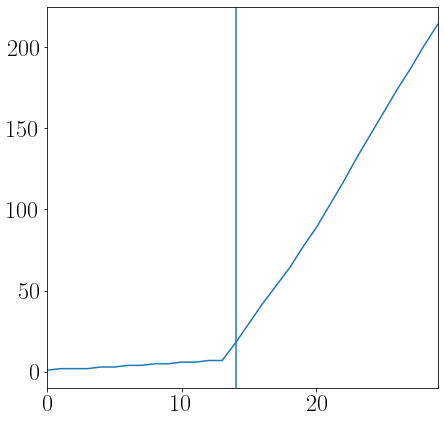

In [10]:
v = 14
print(f'Tolerance {tols[v]}\t Rank {rank_by_tol[v]}')
print(f'Tolerance {tols[v+1]}\t Rank {rank_by_tol[v+1]}')
print(f'Ave {(rank_by_tol[v]+rank_by_tol[v+1])/2}')
    
plt.figure(figsize=(7,7))
plt.plot(rank_by_tol)
plt.axvline(v)
plt.show()

In [6]:
p = np.load('Consistent/Z_35_params.npy')
#np.where(p[0].round(2)==.61)
#np.where(p[2].round(2)==1.61)
# 46 is match for N=35

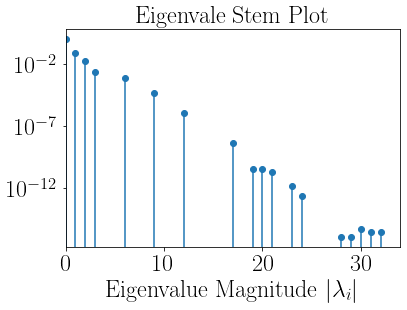

In [7]:
match = 46
p[:,match]
N = 35
a = p[0,match]
g = p[2,match]
K = 1
fname = f'Consistent/Z_{N}_Wnet.npy'
Wr, Wi = rca.get_mats(fname, K,N)
x0 = np.zeros((N,1))
u0 = np.zeros((1,1))
A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
B = rca.partial_u(x0, u0, a, g, Wi, Wr)
Cn35 = rca.controllability_matrix(A,B)
Cn35 = Cn35/np.max(rca.eig_spectrum(Cn35))



rank_by_tol = []
tols = [1/10**x for x in range(0,30)]
for i in tols:
    rank_by_tol.append(rca.rank(Cn35,i))
    
S = np.linalg.svd(Cn35, compute_uv=False)

spec35 = np.linalg.eigvals(Cn35)
fig = plt.figure()
ax = plt.gca()
ax.set_yscale('log')
ax.stem(spec35)
plt.title('Eigenvale Stem Plot')
ax.set_xlabel('Eigenvalue $\lambda_i$')
ax.set_xlabel('Eigenvalue Magnitude $|\lambda_i|$')
plt.show()

Gradients [1.  1.5 2.5 2.5 2.5 2.  2.  2.  1.5 1.5 1.5 1.5 1.  1.5 1.5 3.  3.5 1.5
 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
Tolerance 1e-15	 Rank 27
Tolerance 1e-16	 Rank 32
Ave 29.5


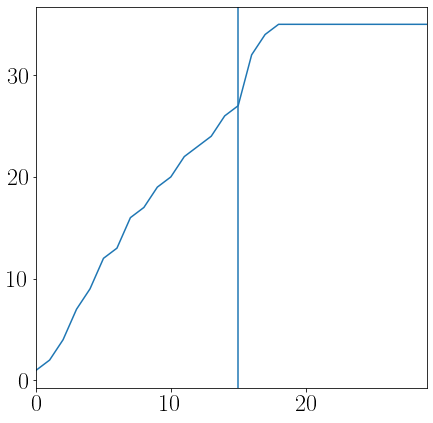

In [8]:
v = 15
print(f'Gradients {np.gradient(rank_by_tol)}')
print(f'Tolerance {tols[v]}\t Rank {rank_by_tol[v]}')
print(f'Tolerance {tols[v+1]}\t Rank {rank_by_tol[v+1]}')
print(f'Ave {(rank_by_tol[v]+rank_by_tol[v+1])/2}')
    
plt.figure(figsize=(7,7))
plt.plot(rank_by_tol)
plt.axvline(v)
plt.show()

In [14]:
spec300 = np.linalg.eigvals(Cn)
fig = plt.figure()
ax = plt.gca()
ax.set_yscale('log')
ax.stem(spec300)
plt.title('Eigenvale Stem Plot')
ax.set_xlabel('Eigenvalue $\lambda_i$')
ax.set_xlabel('Eigenvalue Magnitude $|\lambda_i|$')
plt.show()

NameError: name 'Cn' is not defined

In [11]:
v = 33
print(f'Tolerance {tols[v]}\t Rank {rank_by_tol[v]}')
print(f'Tolerance {tols[v+1]}\t Rank {rank_by_tol[v+1]}')

print(np.gradient(rank_by_tol,1))
    
plt.figure(figsize=(7,7))
plt.plot(rank_by_tol)
plt.axvline(v)
plt.show()

IndexError: list index out of range

In [16]:
(28+16)/2

22.0

In [9]:
start, end = 14000,16000
uVecs = np.zeros((N,2000))
for i in range(start,end):
    uVecs[:,i-14000] = Wi[:,0]*signal[i]

diffs = np.diff(uVecs, axis=1)
norms = np.zeros(2000)
for i in range(diffs.shape[1]):
    norms[i] = np.linalg.norm(diffs[:,i])
np.argmax(norms)

maxX = diffs[:,763][:,np.newaxis]

In [16]:
tau = 2.858*np.median(S)
rca.rank(Cn,tau)

NameError: name 'Cn' is not defined

In [18]:
np.gradient(rank_by_tol,1)

array([1. , 1.5, 2.5, 2.5, 2.5, 2. , 2. , 2. , 1.5, 1.5, 1.5, 1.5, 1. ,
       1.5, 1.5, 3. , 3.5, 1.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. ])

Tolerance 1e-15	 Rank 27
Tolerance 1e-16	 Rank 32


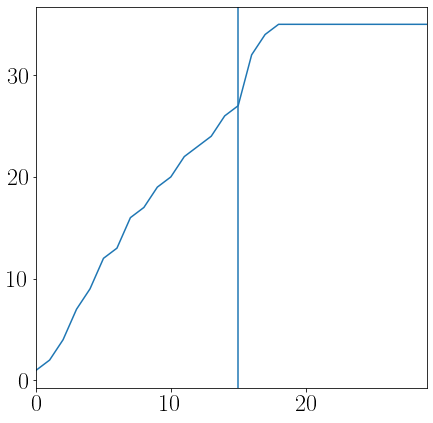

In [10]:
v = 15
print(f'Tolerance {tols[v]}\t Rank {rank_by_tol[v]}')
print(f'Tolerance {tols[v+1]}\t Rank {rank_by_tol[v+1]}')
    
plt.figure(figsize=(7,7))
plt.plot(rank_by_tol)
plt.axvline(v)
plt.show()

In [6]:
preds300 = np.load('Consistent/Z_300_preds.npy')
preds35 = np.squeeze(np.load('Consistent/Z_35_preds.npy'))
preds28 = np.load('models_8_1/Lz_28_preds.npy', allow_pickle=True)

unpreds28 = np.exp(preds28+3.0864)
unpreds35 = np.exp(preds35+3.0864)
unpreds300 = np.exp(preds300+3.0864)

In [14]:
minmax = np.max(unsignal[:15000])-np.min(unsignal[:15000])
NRMSE(unsignal[14000:15000],unpreds35[14000:15000], minmax)

0.1262375194901865

In [12]:
minmax

46.87075369001132

In [11]:
np.var(unsignal[:15000])

73.38549525175269

In [11]:
K=1
tval = v+1
start, end= 13900,15000
target = signal
preds = preds35
sig_rks30, uncSig, cNum, sigradius = rank_along_trajectory( Wr, Wi, a, g,
                                     target[start:end],N, K, tols[tval], maxX)
prd_rks30, uncPrd, cNum, prdradius = rank_along_trajectory( Wr, Wi, a, g,
                                     preds[start:end],N, K, tols[tval], maxX)

Time-step: 0 Rank: 34.0 Uncertainty: 0.18  CondNum: 743.03
Time-step: 1 Rank: 35.0 Uncertainty: 0.25  CondNum: 840.69
Time-step: 2 Rank: 34.0 Uncertainty: 0.31  CondNum: 895.84
Time-step: 3 Rank: 35.0 Uncertainty: 0.36  CondNum: 966.14
Time-step: 4 Rank: 32.0 Uncertainty: 0.40  CondNum: 360.27
Time-step: 5 Rank: 32.0 Uncertainty: 0.43  CondNum: 378.17
Time-step: 6 Rank: 32.0 Uncertainty: 0.47  CondNum: 453.33
Time-step: 7 Rank: 33.0 Uncertainty: 0.50  CondNum: 461.59
Time-step: 8 Rank: 32.0 Uncertainty: 0.53  CondNum: 483.37
Time-step: 9 Rank: 32.0 Uncertainty: 0.56  CondNum: 496.35
Time-step: 10 Rank: 31.0 Uncertainty: 0.58  CondNum: 445.50
Time-step: 11 Rank: 32.0 Uncertainty: 0.61  CondNum: 494.17
Time-step: 12 Rank: 32.0 Uncertainty: 0.63  CondNum: 451.89
Time-step: 13 Rank: 34.0 Uncertainty: 0.65  CondNum: 397.17
Time-step: 14 Rank: 35.0 Uncertainty: 0.68  CondNum: 1055.10
Time-step: 15 Rank: 34.0 Uncertainty: 0.70  CondNum: 794.11
Time-step: 16 Rank: 35.0 Uncertainty: 0.72  CondN

Time-step: 152 Rank: 35.0 Uncertainty: 2.16  CondNum: 756.60
Time-step: 153 Rank: 35.0 Uncertainty: 2.17  CondNum: 862.38
Time-step: 154 Rank: 34.0 Uncertainty: 2.17  CondNum: 944.86
Time-step: 155 Rank: 34.0 Uncertainty: 2.18  CondNum: 603.75
Time-step: 156 Rank: 32.0 Uncertainty: 2.19  CondNum: 327.70
Time-step: 157 Rank: 32.0 Uncertainty: 2.19  CondNum: 342.57
Time-step: 158 Rank: 32.0 Uncertainty: 2.20  CondNum: 405.94
Time-step: 159 Rank: 33.0 Uncertainty: 2.21  CondNum: 417.44
Time-step: 160 Rank: 33.0 Uncertainty: 2.21  CondNum: 417.57
Time-step: 161 Rank: 33.0 Uncertainty: 2.22  CondNum: 403.08
Time-step: 162 Rank: 33.0 Uncertainty: 2.23  CondNum: 305.39
Time-step: 163 Rank: 34.0 Uncertainty: 2.24  CondNum: 1018.50
Time-step: 164 Rank: 35.0 Uncertainty: 2.24  CondNum: 859.55
Time-step: 165 Rank: 34.0 Uncertainty: 2.25  CondNum: 714.39
Time-step: 166 Rank: 35.0 Uncertainty: 2.26  CondNum: 374.01
Time-step: 167 Rank: 35.0 Uncertainty: 2.26  CondNum: 729.74
Time-step: 168 Rank: 34

Time-step: 293 Rank: 33.0 Uncertainty: 3.00  CondNum: 398.17
Time-step: 294 Rank: 34.0 Uncertainty: 3.01  CondNum: 389.23
Time-step: 295 Rank: 34.0 Uncertainty: 3.01  CondNum: 2237.47
Time-step: 296 Rank: 34.0 Uncertainty: 3.02  CondNum: 810.68
Time-step: 297 Rank: 35.0 Uncertainty: 3.02  CondNum: 713.58
Time-step: 298 Rank: 34.0 Uncertainty: 3.03  CondNum: 220264.92
Time-step: 299 Rank: 35.0 Uncertainty: 3.03  CondNum: 363.32
Time-step: 300 Rank: 35.0 Uncertainty: 3.04  CondNum: 371.70
Time-step: 301 Rank: 35.0 Uncertainty: 3.04  CondNum: 365.60
Time-step: 302 Rank: 35.0 Uncertainty: 3.05  CondNum: 738.14
Time-step: 303 Rank: 35.0 Uncertainty: 3.05  CondNum: 859.59
Time-step: 304 Rank: 34.0 Uncertainty: 3.06  CondNum: 891.20
Time-step: 305 Rank: 34.0 Uncertainty: 3.06  CondNum: 989.66
Time-step: 306 Rank: 33.0 Uncertainty: 3.07  CondNum: 298.19
Time-step: 307 Rank: 32.0 Uncertainty: 3.07  CondNum: 418.29
Time-step: 308 Rank: 32.0 Uncertainty: 3.08  CondNum: 473.37
Time-step: 309 Rank:

Time-step: 444 Rank: 32.0 Uncertainty: 3.69  CondNum: 505.05
Time-step: 445 Rank: 32.0 Uncertainty: 3.69  CondNum: 447.29
Time-step: 446 Rank: 34.0 Uncertainty: 3.70  CondNum: 2360.19
Time-step: 447 Rank: 34.0 Uncertainty: 3.70  CondNum: 814.97
Time-step: 448 Rank: 35.0 Uncertainty: 3.71  CondNum: 1337.51
Time-step: 449 Rank: 35.0 Uncertainty: 3.71  CondNum: 751.86
Time-step: 450 Rank: 34.0 Uncertainty: 3.72  CondNum: 714.01
Time-step: 451 Rank: 35.0 Uncertainty: 3.72  CondNum: 361.57
Time-step: 452 Rank: 34.0 Uncertainty: 3.73  CondNum: 373.93
Time-step: 453 Rank: 35.0 Uncertainty: 3.73  CondNum: 361.59
Time-step: 454 Rank: 34.0 Uncertainty: 3.73  CondNum: 483.39
Time-step: 455 Rank: 35.0 Uncertainty: 3.74  CondNum: 792.89
Time-step: 456 Rank: 35.0 Uncertainty: 3.74  CondNum: 912.65
Time-step: 457 Rank: 35.0 Uncertainty: 3.75  CondNum: 1078.68
Time-step: 458 Rank: 34.0 Uncertainty: 3.75  CondNum: 425.88
Time-step: 459 Rank: 33.0 Uncertainty: 3.75  CondNum: 351.48
Time-step: 460 Rank: 

Time-step: 595 Rank: 31.0 Uncertainty: 4.26  CondNum: 423.93
Time-step: 596 Rank: 32.0 Uncertainty: 4.27  CondNum: 470.20
Time-step: 597 Rank: 31.0 Uncertainty: 4.27  CondNum: 531.90
Time-step: 598 Rank: 32.0 Uncertainty: 4.27  CondNum: 534.89
Time-step: 599 Rank: 32.0 Uncertainty: 4.28  CondNum: 503.03
Time-step: 600 Rank: 31.0 Uncertainty: 4.28  CondNum: 436.94
Time-step: 601 Rank: 33.0 Uncertainty: 4.28  CondNum: 416.76
Time-step: 602 Rank: 33.0 Uncertainty: 4.29  CondNum: 317.59
Time-step: 603 Rank: 34.0 Uncertainty: 4.29  CondNum: 426.62
Time-step: 604 Rank: 34.0 Uncertainty: 4.29  CondNum: 1383.81
Time-step: 605 Rank: 35.0 Uncertainty: 4.30  CondNum: 902.85
Time-step: 606 Rank: 35.0 Uncertainty: 4.30  CondNum: 731.71
Time-step: 607 Rank: 35.0 Uncertainty: 4.31  CondNum: 735.72
Time-step: 608 Rank: 35.0 Uncertainty: 4.31  CondNum: 387.57
Time-step: 609 Rank: 35.0 Uncertainty: 4.31  CondNum: 362.36
Time-step: 610 Rank: 35.0 Uncertainty: 4.32  CondNum: 374.04
Time-step: 611 Rank: 35

Time-step: 747 Rank: 32.0 Uncertainty: 4.78  CondNum: 3079.35
Time-step: 748 Rank: 32.0 Uncertainty: 4.78  CondNum: 3022.27
Time-step: 749 Rank: 31.0 Uncertainty: 4.79  CondNum: 792.38
Time-step: 750 Rank: 31.0 Uncertainty: 4.79  CondNum: 881.73
Time-step: 751 Rank: 32.0 Uncertainty: 4.79  CondNum: 569.59
Time-step: 752 Rank: 32.0 Uncertainty: 4.80  CondNum: 452.10
Time-step: 753 Rank: 33.0 Uncertainty: 4.80  CondNum: 416.09
Time-step: 754 Rank: 34.0 Uncertainty: 4.80  CondNum: 502.43
Time-step: 755 Rank: 34.0 Uncertainty: 4.81  CondNum: 9010.10
Time-step: 756 Rank: 35.0 Uncertainty: 4.81  CondNum: 801.36
Time-step: 757 Rank: 34.0 Uncertainty: 4.81  CondNum: 742.45
Time-step: 758 Rank: 34.0 Uncertainty: 4.82  CondNum: 2184.21
Time-step: 759 Rank: 35.0 Uncertainty: 4.82  CondNum: 366.46
Time-step: 760 Rank: 35.0 Uncertainty: 4.82  CondNum: 371.23
Time-step: 761 Rank: 34.0 Uncertainty: 4.83  CondNum: 362.75
Time-step: 762 Rank: 35.0 Uncertainty: 4.83  CondNum: 712.34
Time-step: 763 Rank:

Time-step: 910 Rank: 35.0 Uncertainty: 5.27  CondNum: 809.40
Time-step: 911 Rank: 34.0 Uncertainty: 5.27  CondNum: 748.71
Time-step: 912 Rank: 34.0 Uncertainty: 5.27  CondNum: 715.58
Time-step: 913 Rank: 35.0 Uncertainty: 5.28  CondNum: 2274.88
Time-step: 914 Rank: 35.0 Uncertainty: 5.28  CondNum: 362.18
Time-step: 915 Rank: 35.0 Uncertainty: 5.28  CondNum: 373.41
Time-step: 916 Rank: 34.0 Uncertainty: 5.29  CondNum: 368.89
Time-step: 917 Rank: 35.0 Uncertainty: 5.29  CondNum: 361.47
Time-step: 918 Rank: 34.0 Uncertainty: 5.29  CondNum: 374.64
Time-step: 919 Rank: 35.0 Uncertainty: 5.29  CondNum: 437.85
Time-step: 920 Rank: 35.0 Uncertainty: 5.30  CondNum: 719.68
Time-step: 921 Rank: 35.0 Uncertainty: 5.30  CondNum: 719.05
Time-step: 922 Rank: 35.0 Uncertainty: 5.30  CondNum: 713.80
Time-step: 923 Rank: 35.0 Uncertainty: 5.31  CondNum: 418.35
Time-step: 924 Rank: 35.0 Uncertainty: 5.31  CondNum: 364.50
Time-step: 925 Rank: 34.0 Uncertainty: 5.31  CondNum: 367.43
Time-step: 926 Rank: 35

Time-step: 1046 Rank: 35.0 Uncertainty: 5.66  CondNum: 756.94
Time-step: 1047 Rank: 35.0 Uncertainty: 5.66  CondNum: 720.60
Time-step: 1048 Rank: 35.0 Uncertainty: 5.67  CondNum: 362.75
Time-step: 1049 Rank: 35.0 Uncertainty: 5.67  CondNum: 372.71
Time-step: 1050 Rank: 35.0 Uncertainty: 5.67  CondNum: 362.77
Time-step: 1051 Rank: 35.0 Uncertainty: 5.67  CondNum: 400.94
Time-step: 1052 Rank: 35.0 Uncertainty: 5.68  CondNum: 742.34
Time-step: 1053 Rank: 35.0 Uncertainty: 5.68  CondNum: 887.60
Time-step: 1054 Rank: 35.0 Uncertainty: 5.68  CondNum: 944.82
Time-step: 1055 Rank: 34.0 Uncertainty: 5.69  CondNum: 590.17
Time-step: 1056 Rank: 33.0 Uncertainty: 5.69  CondNum: 302.60
Time-step: 1057 Rank: 33.0 Uncertainty: 5.69  CondNum: 411.68
Time-step: 1058 Rank: 32.0 Uncertainty: 5.69  CondNum: 461.50
Time-step: 1059 Rank: 31.0 Uncertainty: 5.70  CondNum: 499.25
Time-step: 1060 Rank: 32.0 Uncertainty: 5.70  CondNum: 641.81
Time-step: 1061 Rank: 31.0 Uncertainty: 5.70  CondNum: 615.20
Time-ste

Time-step: 99 Rank: 31.0 Uncertainty: 1.73  CondNum: 463.30
Time-step: 100 Rank: 32.0 Uncertainty: 1.74  CondNum: 550.73
Time-step: 101 Rank: 32.0 Uncertainty: 1.75  CondNum: 575.54
Time-step: 102 Rank: 33.0 Uncertainty: 1.75  CondNum: 499.40
Time-step: 103 Rank: 31.0 Uncertainty: 1.76  CondNum: 497.03
Time-step: 104 Rank: 33.0 Uncertainty: 1.77  CondNum: 440.78
Time-step: 105 Rank: 32.0 Uncertainty: 1.78  CondNum: 412.53
Time-step: 106 Rank: 34.0 Uncertainty: 1.79  CondNum: 307.67
Time-step: 107 Rank: 33.0 Uncertainty: 1.80  CondNum: 502.88
Time-step: 108 Rank: 33.0 Uncertainty: 1.81  CondNum: 3274.07
Time-step: 109 Rank: 35.0 Uncertainty: 1.81  CondNum: 727.52
Time-step: 110 Rank: 35.0 Uncertainty: 1.82  CondNum: 732.27
Time-step: 111 Rank: 35.0 Uncertainty: 1.83  CondNum: 721.29
Time-step: 112 Rank: 35.0 Uncertainty: 1.84  CondNum: 363.37
Time-step: 113 Rank: 35.0 Uncertainty: 1.85  CondNum: 370.56
Time-step: 114 Rank: 35.0 Uncertainty: 1.86  CondNum: 368.67
Time-step: 115 Rank: 35.

Time-step: 251 Rank: 31.0 Uncertainty: 2.77  CondNum: 692.28
Time-step: 252 Rank: 33.0 Uncertainty: 2.78  CondNum: 575.30
Time-step: 253 Rank: 32.0 Uncertainty: 2.78  CondNum: 476.18
Time-step: 254 Rank: 32.0 Uncertainty: 2.79  CondNum: 423.72
Time-step: 255 Rank: 33.0 Uncertainty: 2.80  CondNum: 306.10
Time-step: 256 Rank: 34.0 Uncertainty: 2.80  CondNum: 582.19
Time-step: 257 Rank: 34.0 Uncertainty: 2.81  CondNum: 9150.72
Time-step: 258 Rank: 34.0 Uncertainty: 2.81  CondNum: 797.36
Time-step: 259 Rank: 34.0 Uncertainty: 2.82  CondNum: 741.65
Time-step: 260 Rank: 34.0 Uncertainty: 2.82  CondNum: 390.39
Time-step: 261 Rank: 34.0 Uncertainty: 2.83  CondNum: 363.70
Time-step: 262 Rank: 35.0 Uncertainty: 2.84  CondNum: 372.36
Time-step: 263 Rank: 35.0 Uncertainty: 2.84  CondNum: 362.52
Time-step: 264 Rank: 35.0 Uncertainty: 2.85  CondNum: 713.86
Time-step: 265 Rank: 34.0 Uncertainty: 2.85  CondNum: 761.46
Time-step: 266 Rank: 35.0 Uncertainty: 2.86  CondNum: 847.53
Time-step: 267 Rank: 34

Time-step: 409 Rank: 34.0 Uncertainty: 3.54  CondNum: 755.05
Time-step: 410 Rank: 35.0 Uncertainty: 3.54  CondNum: 720.74
Time-step: 411 Rank: 35.0 Uncertainty: 3.55  CondNum: 361.73
Time-step: 412 Rank: 35.0 Uncertainty: 3.55  CondNum: 373.61
Time-step: 413 Rank: 35.0 Uncertainty: 3.56  CondNum: 362.03
Time-step: 414 Rank: 35.0 Uncertainty: 3.56  CondNum: 422.34
Time-step: 415 Rank: 34.0 Uncertainty: 3.57  CondNum: 765.74
Time-step: 416 Rank: 34.0 Uncertainty: 3.57  CondNum: 842.06
Time-step: 417 Rank: 34.0 Uncertainty: 3.58  CondNum: 953.61
Time-step: 418 Rank: 34.0 Uncertainty: 3.58  CondNum: 534.75
Time-step: 419 Rank: 33.0 Uncertainty: 3.58  CondNum: 307.64
Time-step: 420 Rank: 33.0 Uncertainty: 3.59  CondNum: 408.69
Time-step: 421 Rank: 30.0 Uncertainty: 3.59  CondNum: 453.77
Time-step: 422 Rank: 31.0 Uncertainty: 3.60  CondNum: 509.76
Time-step: 423 Rank: 31.0 Uncertainty: 3.60  CondNum: 658.23
Time-step: 424 Rank: 32.0 Uncertainty: 3.60  CondNum: 637.93
Time-step: 425 Rank: 32.

Time-step: 562 Rank: 33.0 Uncertainty: 4.14  CondNum: 4433.47
Time-step: 563 Rank: 26.0 Uncertainty: 4.14  CondNum: 4232.36
Time-step: 564 Rank: 26.0 Uncertainty: 4.14  CondNum: 3475.42
Time-step: 565 Rank: 33.0 Uncertainty: 4.15  CondNum: 4433.81
Time-step: 566 Rank: 31.0 Uncertainty: 4.15  CondNum: 1237.48
Time-step: 567 Rank: 32.0 Uncertainty: 4.15  CondNum: 667.99
Time-step: 568 Rank: 33.0 Uncertainty: 4.16  CondNum: 454.79
Time-step: 569 Rank: 33.0 Uncertainty: 4.16  CondNum: 395.76
Time-step: 570 Rank: 33.0 Uncertainty: 4.17  CondNum: 458.45
Time-step: 571 Rank: 33.0 Uncertainty: 4.17  CondNum: 13420.40
Time-step: 572 Rank: 35.0 Uncertainty: 4.17  CondNum: 811.15
Time-step: 573 Rank: 35.0 Uncertainty: 4.18  CondNum: 741.41
Time-step: 574 Rank: 34.0 Uncertainty: 4.18  CondNum: 6611.79
Time-step: 575 Rank: 34.0 Uncertainty: 4.18  CondNum: 361.57
Time-step: 576 Rank: 35.0 Uncertainty: 4.19  CondNum: 373.35
Time-step: 577 Rank: 35.0 Uncertainty: 4.19  CondNum: 366.93
Time-step: 578 R

Time-step: 721 Rank: 34.0 Uncertainty: 4.70  CondNum: 429.29
Time-step: 722 Rank: 32.0 Uncertainty: 4.70  CondNum: 359.56
Time-step: 723 Rank: 33.0 Uncertainty: 4.71  CondNum: 443.15
Time-step: 724 Rank: 31.0 Uncertainty: 4.71  CondNum: 473.67
Time-step: 725 Rank: 32.0 Uncertainty: 4.71  CondNum: 569.91
Time-step: 726 Rank: 32.0 Uncertainty: 4.72  CondNum: 636.70
Time-step: 727 Rank: 31.0 Uncertainty: 4.72  CondNum: 1082.40
Time-step: 728 Rank: 32.0 Uncertainty: 4.72  CondNum: 2153.71
Time-step: 729 Rank: 31.0 Uncertainty: 4.73  CondNum: 958.81
Time-step: 730 Rank: 31.0 Uncertainty: 4.73  CondNum: 801.07
Time-step: 731 Rank: 30.0 Uncertainty: 4.73  CondNum: 999.81
Time-step: 732 Rank: 31.0 Uncertainty: 4.74  CondNum: 1572.69
Time-step: 733 Rank: 31.0 Uncertainty: 4.74  CondNum: 828.78
Time-step: 734 Rank: 31.0 Uncertainty: 4.74  CondNum: 1562.28
Time-step: 735 Rank: 32.0 Uncertainty: 4.75  CondNum: 654.78
Time-step: 736 Rank: 31.0 Uncertainty: 4.75  CondNum: 517.94
Time-step: 737 Rank:

Time-step: 873 Rank: 35.0 Uncertainty: 5.18  CondNum: 901.46
Time-step: 874 Rank: 34.0 Uncertainty: 5.18  CondNum: 951.85
Time-step: 875 Rank: 33.0 Uncertainty: 5.18  CondNum: 486.86
Time-step: 876 Rank: 34.0 Uncertainty: 5.18  CondNum: 332.27
Time-step: 877 Rank: 32.0 Uncertainty: 5.19  CondNum: 430.77
Time-step: 878 Rank: 32.0 Uncertainty: 5.19  CondNum: 494.41
Time-step: 879 Rank: 31.0 Uncertainty: 5.19  CondNum: 723.65
Time-step: 880 Rank: 31.0 Uncertainty: 5.20  CondNum: 562.77
Time-step: 881 Rank: 31.0 Uncertainty: 5.20  CondNum: 1118.53
Time-step: 882 Rank: 32.0 Uncertainty: 5.20  CondNum: 900.81
Time-step: 883 Rank: 32.0 Uncertainty: 5.20  CondNum: 1000.86
Time-step: 884 Rank: 26.0 Uncertainty: 5.21  CondNum: 3977.01
Time-step: 885 Rank: 26.0 Uncertainty: 5.21  CondNum: 1829.19
Time-step: 886 Rank: 27.0 Uncertainty: 5.21  CondNum: 1168.11
Time-step: 887 Rank: 27.0 Uncertainty: 5.21  CondNum: 860.42
Time-step: 888 Rank: 27.0 Uncertainty: 5.21  CondNum: 691.43
Time-step: 889 Rank

Time-step: 1034 Rank: 32.0 Uncertainty: 5.63  CondNum: 646.47
Time-step: 1035 Rank: 32.0 Uncertainty: 5.63  CondNum: 566.39
Time-step: 1036 Rank: 32.0 Uncertainty: 5.63  CondNum: 608.95
Time-step: 1037 Rank: 32.0 Uncertainty: 5.64  CondNum: 428.67
Time-step: 1038 Rank: 35.0 Uncertainty: 5.64  CondNum: 982.84
Time-step: 1039 Rank: 35.0 Uncertainty: 5.64  CondNum: 740.88
Time-step: 1040 Rank: 35.0 Uncertainty: 5.65  CondNum: 373.03
Time-step: 1041 Rank: 35.0 Uncertainty: 5.65  CondNum: 728.41
Time-step: 1042 Rank: 34.0 Uncertainty: 5.65  CondNum: 420.56
Time-step: 1043 Rank: 33.0 Uncertainty: 5.65  CondNum: 455.58
Time-step: 1044 Rank: 32.0 Uncertainty: 5.66  CondNum: 663.67
Time-step: 1045 Rank: 31.0 Uncertainty: 5.66  CondNum: 1089.81
Time-step: 1046 Rank: 31.0 Uncertainty: 5.66  CondNum: 904.10
Time-step: 1047 Rank: 32.0 Uncertainty: 5.66  CondNum: 1145.81
Time-step: 1048 Rank: 32.0 Uncertainty: 5.67  CondNum: 724.69
Time-step: 1049 Rank: 31.0 Uncertainty: 5.67  CondNum: 577.27
Time-s

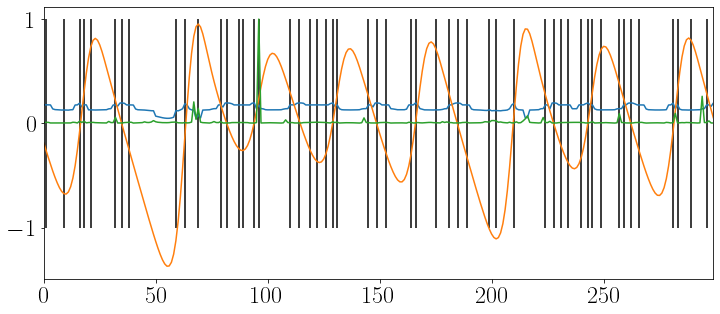

In [30]:
showLen = 300
delYs = np.linalg.norm(uncSig,ord=1,axis=0)
plt.figure(figsize=(12,5))
plt.plot((delYs-delYs.min())[:showLen], label='delta Y')
plt.plot((target[start:end]/np.max(target[start:end]))[:showLen], label='target')
plt.plot(cNum[:showLen]/cNum[:showLen].max(), label='cond_num')
plt.vlines(argrelmax(delYs[:showLen]), color='k', ymin=-1, ymax=1)
plt.show()

In [ ]:
#all_p = np.load('Consistent/Z_300_params.npy')
#all_p[:,66]
#NRMSE(unsignal[14000:15000], unpreds28[14000:15000], std)
#NRMSE(unsignal[14000:15000], unpreds35[14000:15000], std)
#NRMSE(unsignal[14000:15000], unpreds300[14000:15000], std)

In [22]:
#yhat1000 = preds1000[14000:]
#yhat300 = preds300[14000:]
#yhat35 = preds35[14000:]

mx = 48. #np.min([np.max(signal[14000:]), np.max(yhat35), np.max(yhat300), np.max(yhat1000)])
mn = 0.  #np.max([np.min(signal[14000:]), np.min(yhat35), np.min(yhat300), np.min(yhat1000)])

In [19]:
sig_rks35.shape

(1100,)

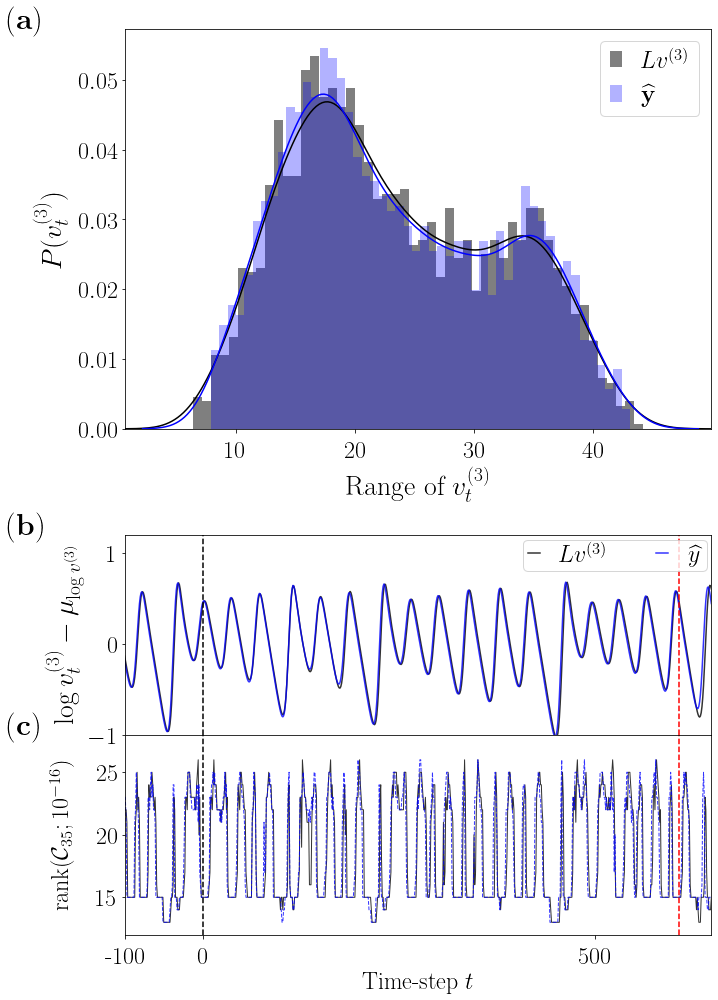

In [28]:
#import string
gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(10,14))
ax1 = plt.subplot(gs[0])
fontsize = 28


data_dict = {'y': unsignal[-2000:],
             'yh35': unpreds35[-2000:],
            }
alpha = .5
bins = 50 #np.arange(0,48,48/75)#17
df = pd.DataFrame(data=data_dict)
sns.distplot(df['y'],
             label='$Lv^{(3)}$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.5),
             ax=ax1)
sns.distplot(df['yh35'],
             label='$\widehat{\mathbf{y}}$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.3),
             ax=ax1)
ax1.legend(handlelength=.5,loc='upper right', fontsize=fontsize-4)
ax1.set_ylabel(r'${P}(v^{(3)}_t)$', fontsize=fontsize,  color='black', weight='heavy', labelpad=10)
ax1.set_xlabel(r'Range of $v^{(3)}_t$', fontsize=fontsize,  color='black', weight='heavy')
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')



start, end= 13900,14650
xax = [k for k in range(start,end)]
plt.rcParams['xtick.major.pad']='8'
gs1 = gs[1].subgridspec(2,1, hspace=0)
#gs1.update(wspace=0.025, hspace=0.0)

ax2 = plt.subplot(gs1[0])

ax2.plot(xax,signal[start:end],'k', label=r'$Lv^{(3)}$', alpha= .8)
ax2.plot(xax,preds35[start:end],'b-', label='$\widehat{y}$', alpha = .8)

ax2.legend(loc='upper right',
           handlelength=.5,
           ncol=2,
           fontsize=24,
           borderpad=.2,
           borderaxespad=.2)
#ax2.set_xticks([0,100,500,1000,1100])
#ax2.set_xticklabels([-100,0,500,1100,])
#ax2.set_xlabel(r'Test Data Time-steps t', fontsize=fontsize, color='black', weight='heavy')
ax2.set_ylabel(r'$\log{v^{(3)}_t}-\mu_{\log{v^{(3)}}}$', fontsize=fontsize,  color='black', weight='heavy')
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.set_xticks([])
ax2.set_ylim(-1, 1.2)

sig_rks35 = np.load('Consistent/Ranks/Z_35_sig_rks35.npy')
prd_rks35 = np.load('Consistent/Ranks/Z_35_prd_rks35.npy')
ax3 = plt.subplot(gs1[1])
ax3.text(-0.2, 0,s='$(\mathbf{c})$', transform=ax2.transAxes, 
            size=30, weight='bold')

ax3.plot(xax,sig_rks35[:750],
        color='k', lw=1, label='$Lv^{(3)}$', alpha=.8)
ax3.plot(xax,prd_rks35[:750],
        color= 'b', ls='--', lw=1, label='$\widehat{\mathbf{y}}$', alpha=.8)

ax3.set_ylim(12, 28)
ax3.set_ylabel('$\mathrm{rank}(\mathbf{\mathcal{C}}_{35};10^{-16})$', labelpad=22)
ax3.set_xlabel('Time-step $t$')
#ax3.legend(loc='upper right',
#           handlelength=.5,
#           ncol=2,
#           fontsize=24,
#           borderpad=.2,
#           borderaxespad=.2)
ax3.set_xticks([13900,14000,14500])
ax3.set_xticklabels([-100,0,500])

maxradii = list(set((argrelmax(sigradius)[0]).tolist()) & set((np.where(sigradius>1)[0]).tolist())) 

ax2.axvline(14000, c='k',ls='dashed' )
ax2.axvline(14608, c='r',ls='dashed' )
#ax2.vlines(np.array(maxradii) + 13900, -1,1, color='k', linewidths=1, ls='dotted')
#ax3.vlines(np.array(maxradii) + 13900, 10,30, color='k', linewidths=1, ls='dotted')
ax3.axvline(14000, c='k',ls='dashed' )
ax3.axvline(14608, c='r',ls='dashed' )
plt.tight_layout()
plt.show()
fig.savefig("../ChaosPlots/Lz_lines_combined.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)

k-size=5 Trainingset min=0.77707  threshold=0.73822  Location=178
k-size=10 Trainingset min=0.89819  threshold=0.85328  Location=481
k-size=20 Trainingset min=0.93645  threshold=0.88962  Location=472
k-size=30 Trainingset min=0.96217  threshold=0.91406  Location=612
k-size=35 Trainingset min=0.9608  threshold=0.91276  Location=608


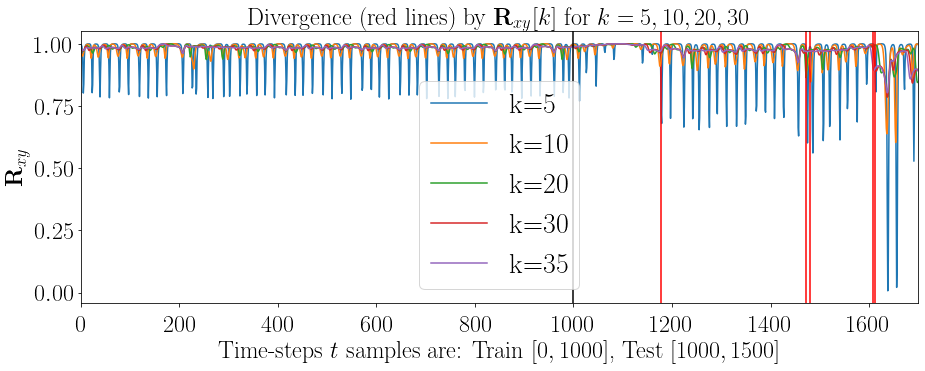

In [64]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))

k_list = [5,10,20,30,35]
start, stop = 13000, 15500  #Depends on dataset should be last 1000 train to 500 of free-run
plt.figure(figsize=(15,5))
for k in k_list:
    trainCorr = np.zeros((stop-start)-k)
    for j in range(start, stop-k):
        tar = target[j:j+k].reshape((k,1))
        prd = preds35[j:j+k].reshape((k,1))
        trainCorr[j-start] = Rxy(tar,prd)
    minVal = trainCorr[:1000].min()
    threshold = minVal-(minVal*.05)
    thresholdLoc = np.where(trainCorr[1000:2000]<threshold)[0][0]
    print(f'k-size={k} Trainingset min={trainCorr[:1000].min().round(5)}  threshold={threshold:.5f}',
          f' Location={thresholdLoc}')
    plt.plot(trainCorr[:1700], label=f'k={k}')
    plt.axvline(1000+thresholdLoc,color='r')
plt.ylabel('$\mathbf{R}_{xy}$')
plt.xlabel('Time-steps $t$ samples are: Train $[0,1000]$, Test $[1000,1500]$')
plt.legend(fontsize=28)
plt.axvline(1000,color='k') #End trainset
plt.title('Divergence (red lines) by $\mathbf{R}_{xy}[k]$ for $k=5,10,20,30$')
plt.show()